### Classifier with TF-IDF vectors
Dataset size:
* Train: 50,000
* Test: 5,000

TF-IDF vectors:
* max_features: 8,000
* min_df: 10

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import cross_validate
from sklearn import svm
import pickle
import sys
import keras
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
train_set = pd.read_csv("dataset_train_pp.csv")
test_set = pd.read_csv("dataset_test_pp.csv")

In [3]:
print(len(train_set))
print(len(test_set))

50000
5000


In [4]:
train_x=train_set["Description"]
test_x=test_set["Description"]

train_y=train_set["Class Index"]
test_y=test_set["Class Index"]

In [6]:
%%time
test_x_vectors = np.load("tfidf_test_x_8000.npy")

CPU times: user 24.5 ms, sys: 435 ms, total: 460 ms
Wall time: 11.3 s


In [7]:
%%time
train_x_vectors = np.load("tfidf_train_x_8000.npy")

CPU times: user 44.5 ms, sys: 4.67 s, total: 4.71 s
Wall time: 2min 3s


In [7]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion_matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], 
                horizontalalignment='center', 
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bays

In [8]:
naive_bays = MultinomialNB()

In [9]:
%%time
naive_bays.fit(train_x_vectors, train_y)

CPU times: user 7.14 s, sys: 813 ms, total: 7.95 s
Wall time: 3.5 s


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
p = pickle.dumps(naive_bays)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

640.749


In [11]:
%%time
nb_pred_x = naive_bays.predict(test_x_vectors)

CPU times: user 432 ms, sys: 17.8 ms, total: 450 ms
Wall time: 167 ms


In [12]:
accuracy_score(test_y,nb_pred_x)

0.8804

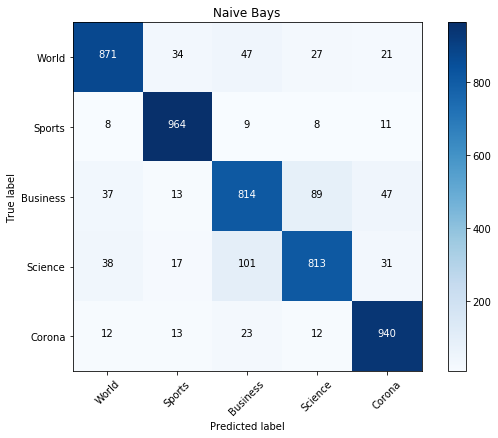

In [13]:
nb_cm = confusion_matrix(test_y, nb_pred_x)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nb_cm, cmPlotLabels, title='Naive Bays')

### SVM

This step is skipped due to long process time

In [13]:
# svm_model = svm.SVC(kernel='poly', degree=2, gamma='scale')

In [ ]:
# %%time
# svm_model.fit(train_x_vectors, train_y)

In [ ]:
# svm_pred_x = svm_model.predict(test_x_vectors)

In [ ]:
# accuracy_score(test_y,svm_pred_x)

In [ ]:
# svm_cm = confusion_matrix(test_y, svm_pred_x)
# plot_confusion_matrix(svm_cm, cmPlotLabelstitle='SVM, deg=1')

### NN

#### Prepare labels for keras

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')

In [9]:
test_y_array = test_y.to_numpy().reshape(-1,1)
train_y_array = train_y.to_numpy().reshape(-1,1)

In [10]:
enc.fit(test_y_array)
test_y_1hot = enc.transform(test_y_array).toarray()

In [11]:
enc.fit(train_y_array)
train_y_1hot = enc.transform(train_y_array).toarray()

#### keras model

In [13]:
nn_model = None
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(32, input_dim=8000, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(5, activation='softmax'))

In [14]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                256032    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 256,917
Trainable params: 256,917
Non-trainable params: 0
_________________________________________________________________


In [16]:
nn_model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
%%time
nn_model.fit(train_x_vectors, train_y_1hot, epochs=10, batch_size=10)

W0618 17:40:35.393451 139720076633856 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0618 17:40:35.529438 139720076633856 deprecation_wrapper.py:119] From /home/amirhossein/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
50000/50000 [==============================] - 56s 1ms/step - loss: 0.3779 - acc: 0.8725
Epoch 2/10
50000/50000 [==============================] - 54s 1ms/step - loss: 0.1955 - acc: 0.9345
Epoch 3/10
50000/50000 [==============================] - 53s 1ms/step - loss: 0.1375 - acc: 0.9524
Epoch 4/10
50000/50000 [==============================] - 56s 1ms/step - loss: 0.0942 - acc: 0.9671
Epoch 5/10
50000/50000 [==============================] - 58s 1ms/step - loss: 0.0606 - acc: 0.9787
Epoch 6/10
50000/50000 [==============================] - 59s 1ms/step - loss: 0.0358 - acc: 0.9874
Epoch 7/10
50000/50000 [==============================] - 59s 1ms/step - loss: 0.0230 - acc: 0.9923
Epoch 8/10
50000/50000 [==============================] - 59s 1ms/step - loss: 0.0159 - acc: 0.9947
Epoch 9/10
50000/50000 [==============================] - 60s 1ms/step - loss: 0.0111 - acc: 0.9964
Epoch 10/10
50000/50000 [==============================] - 60s 1ms/step - loss: 0.0085 - acc: 0.9974

In [18]:
p = pickle.dumps(nn_model)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

3094.412


In [19]:
nn_model.evaluate(test_x_vectors, test_y_1hot, batch_size=10)

5000/5000 [==============================] - 1s 274us/step


[0.9567429420530039, 0.8825999945998192]

In [20]:
%%time
predictions = nn_model.predict(test_x_vectors)

CPU times: user 726 ms, sys: 39.2 ms, total: 765 ms
Wall time: 571 ms


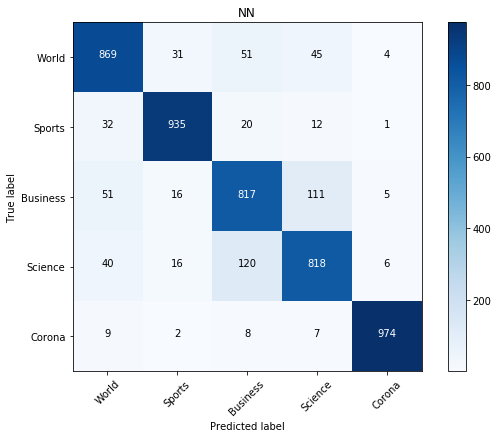

In [21]:
nn_cm = confusion_matrix(test_y, predictions.argmax(axis=1)+1)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nn_cm, cmPlotLabels, title='NN')

In [22]:
nn_model.save("nn_tfidf_8000.h5")